# Recherche d'une image dans une base indexée


#Les Inputs

**Installation du package d'LSH**

In [ ]:
!pip install lshash3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 27.5 MB/s 
  Created wheel for lshash3: filename=lshash3-0.0.8-py2.py3-none-any.whl size=10164 sha256=d3dc682fa4b8615ce5dee775a8dbefd134d74fe61e2e90f9c23524e7b5e5dc0b
  Stored in directory: /root/.cache/pip/wheels/65/72/01/dd1b56064187746f99aa560bbc491048575621ce6bb37cd05a
Successfully built lshash3


**chargement des librairies néccesaires**

In [ ]:
import pandas as pd
import numpy as np
import random
import time
from lshash.lshash import LSHash
import gdown
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import cv2 as cv
import sys
import os
from tqdm import tqdm
from google.colab.patches import cv2_imshow
from tqdm import tqdm
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA

**Chargement des données**

In [ ]:
#telechargement des données
train_url ="https://drive.google.com/uc?id=1bIk655RU3YXdwdTWrG-sRHWk8MrDtpFR"
output="train.zip"
gdown.download(train_url, output, quiet=False)
!unzip -d train "train.zip"
frame_url ="https://drive.google.com/uc?id=1BLK6ApQBPdA_0nABJcCIBRRM2Cb8fPEY"
output="frame.zip"
gdown.download(frame_url, output, quiet=False)
!unzip -d frame "frame.zip"

In [ ]:
#fonction de chargement des images d'entrainements et de tests
def load_data(dataset_directory):
    train_images= {}
    for filename in os.listdir(dataset_directory):
        #get path
        #current_folder=filename.split('_')[0]
        if filename.split('.')[1]=="jpg":
          path_folder = dataset_directory
          #print(path_folder)
          # find the keypoints and descriptors with SIFT
          current_image=cv.imread(path_folder+filename);
          train_images[path_folder+filename]=current_image;
    return train_images;

In [ ]:
#chargement des images d'entrainements et de tests
train_images=load_data("train/")
print("nombre total d'image d'entrainement")
print(len(train_images))

nombre total d'image d'entrainement
45


#Définitions des fonctions utiles

In [ ]:
#fonction d'affichage des images
def display_images(train_images):
  plt.figure(figsize=(50, 50))
  for i in range(1):
    key=random.choice(list(train_images.keys()))
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(train_images[key], cmap='gray')
    plt.title(key)
    plt.axis("off")

#fonction de conversion d'image en gray
def convert_to_gray(train_images):
  train_gray_images={}
  for key in train_images:
    train_gray_images[key]=cv.cvtColor(train_images[key], cv.COLOR_RGB2GRAY)
  return train_gray_images

#fonction de calcul de descripteurs sift
def describeImages(train_gray_images,train_images,type,max_features):
  if "sift" in type:
    des_type = cv.SIFT_create(max_features)
  else:
    if "orb" in type:
      des_type=  cv.ORB_create(max_features)
    else:
      des_type = cv.xfeatures2d.SURF_create(max_features)
  descriptors= {}
  keypoints={}
  draws={}
  with tqdm(total=len(train_images), desc="Calcul de descripteur", bar_format="{l_bar}{bar} [ time left: {remaining} ]") as pbar:
    for key in train_gray_images:
      current_kp, current_des = des_type.detectAndCompute(train_gray_images[key],None)
      descriptors[key]=current_des;
      draws[key]=cv.drawKeypoints(train_gray_images[key], current_kp, train_images[key].copy(), flags = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
      keypoints[key]=current_kp;
      pbar.update(1)
    return descriptors, keypoints,draws


#fonction de calcul de descripteurs sift without max
def describeImagesWithoutMax(train_gray_images,train_images,type):
  if "sift" in type:
    des_type = cv.SIFT_create()
  else:
    if "orb" in type:
      des_type=  cv.ORB_create()
    else:
      des_type = cv.xfeatures2d.SURF_create()
  descriptors= {}
  keypoints={}
  draws={}
  with tqdm(total=len(train_images), desc="Calcul de descripteur", bar_format="{l_bar}{bar} [ time left: {remaining} ]") as pbar:
    for key in train_gray_images:
      current_kp, current_des = des_type.detectAndCompute(train_gray_images[key],None)
      descriptors[key]=current_des;
      draws[key]=cv.drawKeypoints(train_gray_images[key], current_kp, train_images[key].copy(), flags = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
      keypoints[key]=current_kp;
      pbar.update(1)
    return descriptors, keypoints,draws

affichage de quelques images


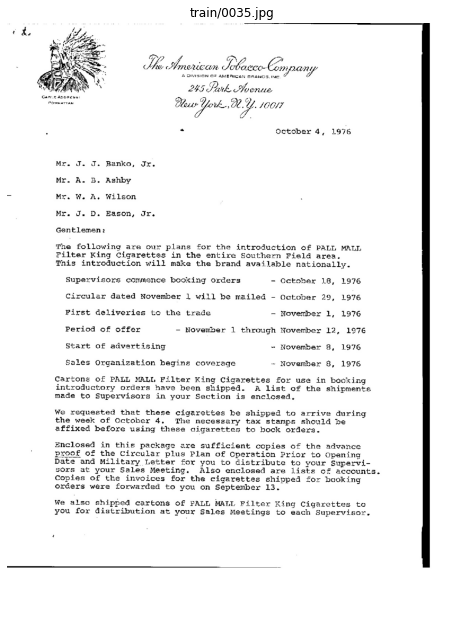

In [ ]:
print("affichage de quelques images")
display_images(train_images)

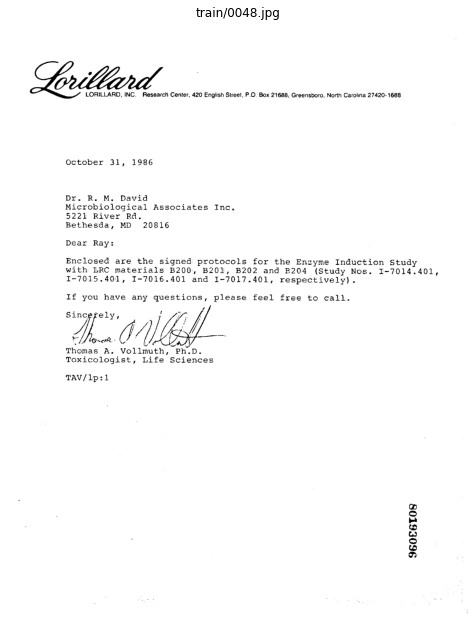

In [ ]:
#convertion images de train et test en gray
train_gray_images=convert_to_gray(train_images)
#affichage des images de traitement en gray
display_images(train_gray_images)

In [ ]:
descriptors,keypoints,draws=describeImagesWithoutMax(train_gray_images, train_images,"sift")

Calcul de descripteur: 100%|██████████ [ time left: 00:00 ]


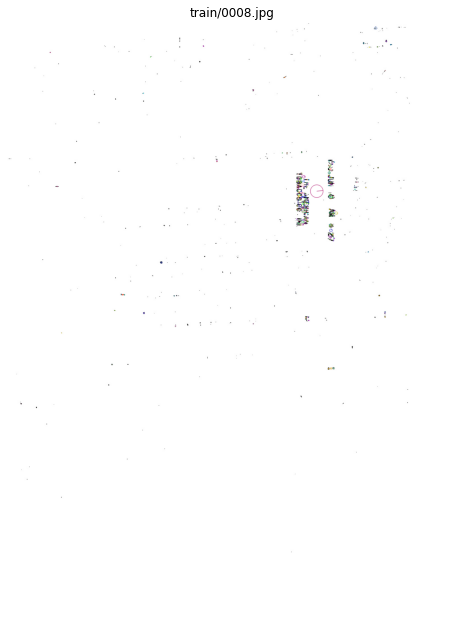

In [ ]:
display_images(draws)

In [ ]:
#affichage des desctipteurs
len(descriptors['train/0030.jpg'])

21037

#Essai de reduction des descripteurs avec PCA

[reduction_pca](https://colab.research.google.com/drive/11M2_YHni6InLaV-L9alyjneSeNNO6iFE#scrollTo=VbkyzAQgakVe)

#Indexation des descripteurs

In [ ]:
#descripteur des images train
#Reduction des descripteurs à 150
descriptors,keypoints,draws=describeImages(train_gray_images, train_images,"sift",150)

Calcul de descripteur: 100%|██████████ [ time left: 00:00 ]


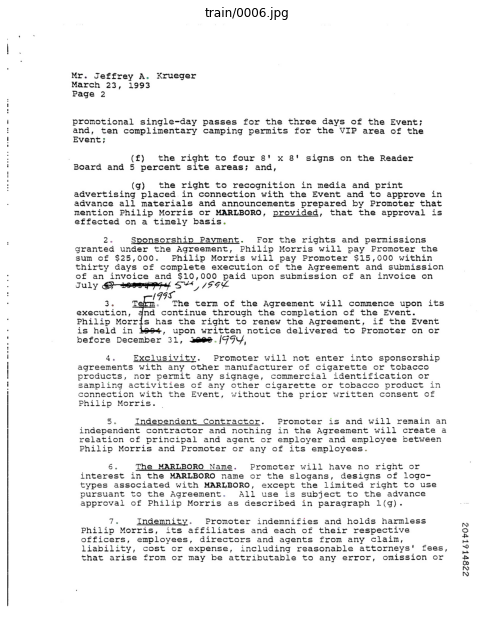

In [ ]:
display_images(draws)

In [ ]:
#affichage des desctipteurs
df_descriptors = pd.DataFrame.from_dict(descriptors.values())
df_descriptors.index=descriptors.keys()
df_descriptors

/usr/local/lib/python3.7/dist-packages/pandas/core/internals/construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


,0
train/0041.jpg,"[[58.0, 15.0, 11.0, 29.0, 77.0, 0.0, 0.0, 4.0,..."
train/0028.jpg,"[[11.0, 10.0, 0.0, 0.0, 7.0, 129.0, 44.0, 5.0,..."
train/0006.jpg,"[[0.0, 0.0, 1.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
train/0055.jpg,"[[0.0, 0.0, 9.0, 117.0, 24.0, 0.0, 0.0, 0.0, 0..."
train/0043.jpg,"[[0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
train/0049.jpg,"[[0.0, 0.0, 1.0, 5.0, 1.0, 0.0, 0.0, 0.0, 0.0,..."
train/0045.jpg,"[[0.0, 0.0, 1.0, 6.0, 1.0, 0.0, 0.0, 0.0, 0.0,..."
train/0017.jpg,"[[26.0, 31.0, 44.0, 17.0, 3.0, 8.0, 80.0, 24.0..."
train/0010.jpg,"[[3.0, 3.0, 83.0, 62.0, 11.0, 47.0, 11.0, 1.0,..."
train/0048.jpg,"[[0.0, 0.0, 0.0, 9.0, 10.0, 0.0, 0.0, 0.0, 3.0..."


In [ ]:
# fonction des indexation_descripteurs_bases
def indexation_descripteurs_bases(descriptors,num_dim,num_tables):
  lsh = LSHash(12, num_dim, num_tables)
  for key in descriptors:
    if descriptors[key] is not None:
      for vector in descriptors[key]:
        lsh.index(vector, extra_data=key)
  return lsh

In [ ]:
#dimension
num_dim=len(descriptors['train/0030.jpg'][0])
print(num_dim)
#nombre de tables hash
num_tables=5
lsh=indexation_descripteurs_bases(descriptors,num_dim,num_tables)

128


In [ ]:
#affichage des tables de hash
lsh.hash_tables

In [ ]:
#affichage des clés de la première table de hash
list(lsh.hash_tables[0].keys())[:5]

['000011110110',
 '001011100110',
 '011111110110',
 '111111111110',
 '111101010110']

In [ ]:
#taille des données de la première clé de la première table de hash
len(lsh.hash_tables[0].keys())

476

In [ ]:
#affichage du vecteur
for key in lsh.hash_tables[0].keys():
    print(key)
    print(lsh.hash_tables[0].get_val(key)[0][1])
    print(lsh.hash_tables[0].get_val(key)[0][0])
    break;

000011110110
train/0041.jpg
(58.0, 15.0, 11.0, 29.0, 77.0, 0.0, 0.0, 4.0, 46.0, 44.0, 26.0, 24.0, 18.0, 22.0, 37.0, 28.0, 74.0, 12.0, 14.0, 28.0, 55.0, 50.0, 18.0, 3.0, 107.0, 8.0, 2.0, 13.0, 69.0, 0.0, 0.0, 2.0, 70.0, 14.0, 1.0, 9.0, 111.0, 7.0, 0.0, 3.0, 111.0, 69.0, 17.0, 15.0, 37.0, 19.0, 9.0, 35.0, 108.0, 5.0, 8.0, 31.0, 90.0, 49.0, 7.0, 11.0, 111.0, 0.0, 0.0, 4.0, 111.0, 1.0, 0.0, 4.0, 54.0, 2.0, 0.0, 0.0, 66.0, 111.0, 14.0, 16.0, 69.0, 86.0, 32.0, 15.0, 23.0, 77.0, 30.0, 9.0, 100.0, 20.0, 31.0, 58.0, 59.0, 11.0, 26.0, 25.0, 111.0, 0.0, 0.0, 2.0, 111.0, 11.0, 2.0, 18.0, 9.0, 0.0, 0.0, 0.0, 4.0, 60.0, 16.0, 21.0, 0.0, 5.0, 5.0, 1.0, 4.0, 83.0, 111.0, 0.0, 18.0, 2.0, 5.0, 5.0, 1.0, 3.0, 111.0, 53.0, 23.0, 0.0, 0.0, 0.0, 22.0, 32.0, 21.0, 38.0)


In [ ]:
df_lshtables = pd.DataFrame(lsh.hash_tables[0].get_val('001011100110'))
df_lshtables

,0,1
0,"(13.0, 23.0, 35.0, 77.0, 47.0, 3.0, 1.0, 0.0, ...",train/0041.jpg
1,"(3.0, 0.0, 0.0, 90.0, 73.0, 0.0, 0.0, 2.0, 50....",train/0027.jpg
2,"(0.0, 0.0, 0.0, 32.0, 130.0, 37.0, 0.0, 0.0, 0...",train/0046.jpg


In [ ]:
#obtention d'un frame d'une video pour le test
def getFrame(the_video):
  vidcap = cv.VideoCapture(the_video)
  _,image = vidcap.read()
  image_name='frame/'+str((the_video.split('/')[1]).split('.')[0])+".jpg"
  cv.imwrite(image_name,image)
  return image_name

In [ ]:
test_image_name=getFrame("test/2-TL.mp4")
print(type(test_image_name))

<class 'str'>


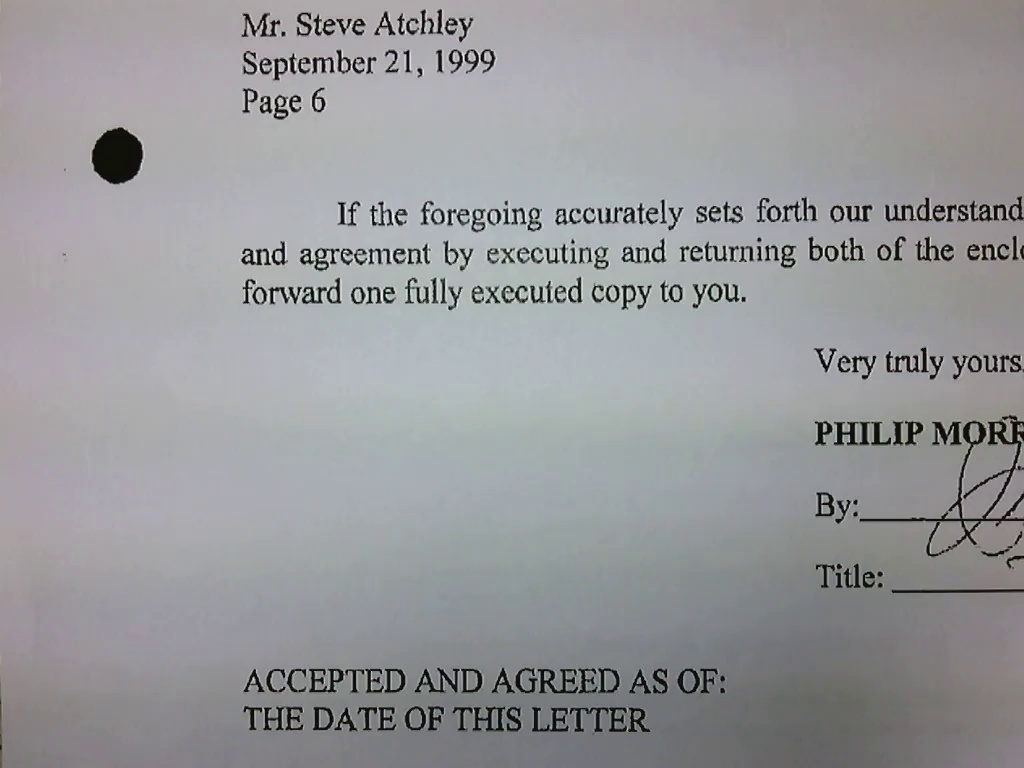

In [ ]:
#affichage du frame
cv2_imshow(cv.imread(test_image_name))

In [ ]:
#fonction d'obtention des frames images de tous nos videos
def getAllFrame(dataset_directory):
  for filename in os.listdir(dataset_directory):
    getFrame(dataset_directory+filename)

In [ ]:
#reccuperation des frames de tous les videos
getAllFrame("test/")

In [ ]:
#chargement des frames
frame_images=load_data("frame/")

In [ ]:
len(frame_images)

138

In [ ]:
#conversion des images  frame en gray
frame_gray_images=convert_to_gray(frame_images)

In [ ]:
#calcul descripteur image test
frame_descriptors,frame_keypoints,frame_draws=describeImages(frame_gray_images, frame_images,"sift",150)

Calcul de descripteur: 100%|██████████ [ time left: 00:00 ]


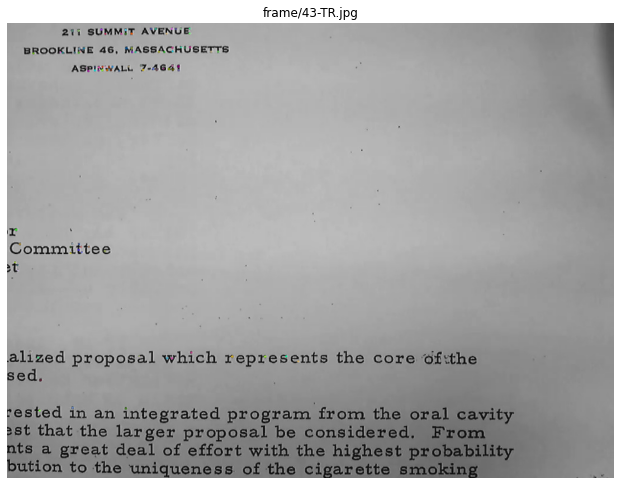

In [ ]:
#affichage des descripteurs et images frame
display_images(frame_draws)

#Requete d'une image donnée

In [ ]:
#exemple requette index
nn = lsh.query(frame_descriptors['frame/38-BL.jpg'][0], num_results=1, distance_func="euclidean")
for ((vec,extra_data),distance) in nn:
  print(vec)
  print(extra_data, distance)

(130.0, 4.0, 2.0, 2.0, 24.0, 29.0, 12.0, 52.0, 62.0, 27.0, 1.0, 1.0, 113.0, 103.0, 9.0, 8.0, 131.0, 59.0, 0.0, 2.0, 22.0, 10.0, 2.0, 1.0, 17.0, 7.0, 1.0, 16.0, 131.0, 30.0, 1.0, 1.0, 131.0, 16.0, 0.0, 3.0, 43.0, 14.0, 4.0, 21.0, 65.0, 10.0, 0.0, 21.0, 131.0, 51.0, 7.0, 10.0, 131.0, 35.0, 0.0, 4.0, 32.0, 12.0, 5.0, 27.0, 29.0, 4.0, 0.0, 2.0, 108.0, 122.0, 4.0, 2.0, 65.0, 1.0, 0.0, 0.0, 13.0, 29.0, 42.0, 103.0, 17.0, 0.0, 0.0, 2.0, 63.0, 131.0, 81.0, 36.0, 89.0, 1.0, 0.0, 0.0, 4.0, 19.0, 68.0, 125.0, 14.0, 0.0, 0.0, 0.0, 4.0, 58.0, 11.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 19.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 22.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 19.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 2.0)
train/0049.jpg 46275.0


In [ ]:
def requetter_document(req_descriptors):
  results={}
  for vector in req_descriptors:
    nn = lsh.query(vector, num_results=1, distance_func="euclidean")
    for ((vec,extra_data),distance) in nn:
        #current_result=(extra_data.split('.')[0]).split('__')[0]
        current_result=extra_data
        if current_result in results:
          results[current_result]+=1
        else:
          results[current_result]=1
  return results

#Les Outputs

In [ ]:
#exemple de requette de documents
results=requetter_document(frame_descriptors['frame/4-BR.jpg'])
list(results.items())[:20]

[('train/0006.jpg', 15),
 ('train/0010.jpg', 3),
 ('train/0004.jpg', 17),
 ('train/0053.jpg', 1),
 ('train/0015.jpg', 12),
 ('train/0037.jpg', 15),
 ('train/0002.jpg', 10),
 ('train/0023.jpg', 2),
 ('train/0027.jpg', 6),
 ('train/0030.jpg', 2),
 ('train/0048.jpg', 12),
 ('train/0025.jpg', 4),
 ('train/0001.jpg', 10),
 ('train/0041.jpg', 8),
 ('train/0031.jpg', 1),
 ('train/0038.jpg', 2),
 ('train/0033.jpg', 1),
 ('train/0057.jpg', 1),
 ('train/0020.jpg', 3),
 ('train/0017.jpg', 1)]

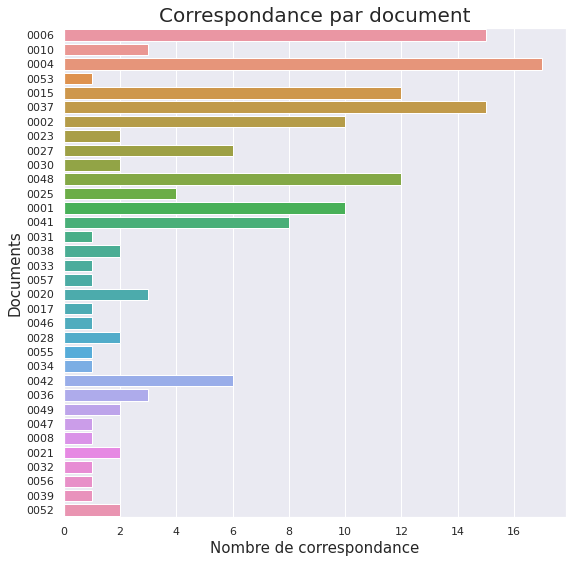

In [ ]:
#presentation des resultats
keys = [(i.split('/')[1]).split('.')[0] for i in results]
list(results.keys())
vals = [int(results[k]) for k in results]
sns.set()
plt.figure(figsize = (9,9))
sns.barplot(x=vals, y=keys)
plt.title("Correspondance par document", fontsize = 20)
plt.ylabel("Documents", fontsize = 15)
plt.xlabel("Nombre de correspondance", fontsize = 15)
plt.savefig("Correspondance par documents")
plt.show()

In [ ]:
#fonction de tri
def get_sorted_results(results):
  sorted_similiraties_values = sorted(results.values(), reverse=True)
  sorted_results = {}
  i=0
  for i in sorted_similiraties_values:
      for k in results.keys():
          if results[k] == i:
              sorted_results[k] = results[k]
      if len(sorted_results)>=10:
        break
  return sorted_results

In [ ]:
#resultats triés
sorted_results=get_sorted_results(results)
list(sorted_results.items())[:3]

[('train/0004.jpg', 17), ('train/0006.jpg', 15), ('train/0037.jpg', 15)]

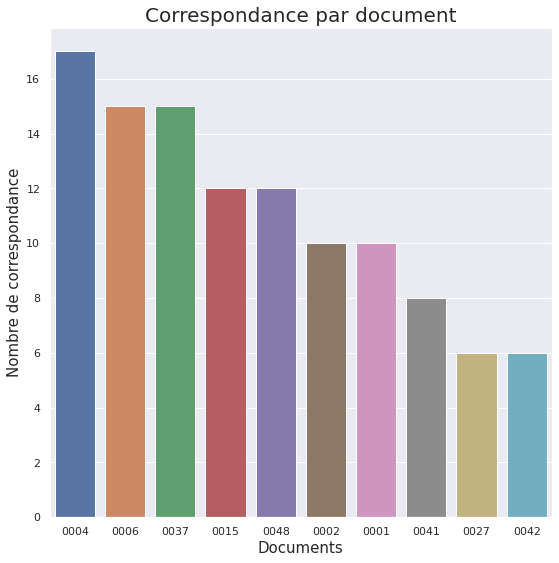

In [ ]:
#presentation des resultats
keys = [(i.split('/')[1]).split('.')[0] for i in sorted_results]
list(sorted_results.keys())
vals = [int(sorted_results[k]) for k in sorted_results]
sns.set()
plt.figure(figsize = (9,9))
sns.barplot(x=keys, y=vals)
plt.title("Correspondance par document", fontsize = 20)
plt.ylabel("Nombre de correspondance", fontsize = 15)
plt.xlabel("Documents", fontsize = 15)
plt.savefig("Correspondance par documents")
plt.show()


#EVALUATION DU MODELE

In [ ]:
#fonction de dectection sur tous nos frames
def predict(frame_descriptors, frame_images,seuil):
  predictions=[0]*len(frame_images)
  true_labels=[0]*len(frame_images)
  n_compteur=0
  with tqdm(total=len(frame_images), desc="Prediction", bar_format="{l_bar}{bar} [ time left: {remaining} ]") as pbar:
    for n_key in frame_descriptors:
        sorted_results = get_sorted_results(requetter_document(frame_descriptors[n_key]))
        current_true=str(((n_key.split('/')[1]).split('.')[0]).split('-')[0])
        current_true=current_true.rjust(4,"0")
        if('train/'+str(current_true)+'.jpg' in list(sorted_results)[:seuil]):
          predictions[n_compteur]=current_true
        else:
          current_result=list(sorted_results.keys())[0]
          predictions[n_compteur]=current_result.split('/')[1].split('.')[0]
        true_labels[n_compteur]=current_true
        n_compteur+=1
        pbar.update(1)
  return np.array(predictions),np.array(true_labels)

**PREDICTION SUR LE PREMIER DOCUMENT TROUVE SEUIL(1)**

In [ ]:
#calcul des prédiction de tous les images test
predictions_1,true_labels=predict(frame_descriptors, frame_images,1)

Prediction: 100%|██████████ [ time left: 00:00 ]


In [ ]:
#affichage des labels uniques
def displayConfusioMatrix(true_labels,predictions):
  confm = confusion_matrix(true_labels,predictions,labels=np.unique(true_labels))
  df_cm = pd.DataFrame(confm, index = [i for i in np.unique(true_labels)],
                columns = [i for i in np.unique(true_labels)])
  plt.figure(figsize = (30,30))
  plt.title('Confusion Matrix', fontsize = 20)
  sns.heatmap(df_cm, annot=True, cmap="YlGnBu", linewidths=.5)
  plt.xlabel('Actual', fontsize = 15)
  plt.ylabel('Predicted', fontsize = 15)
  plt.show()

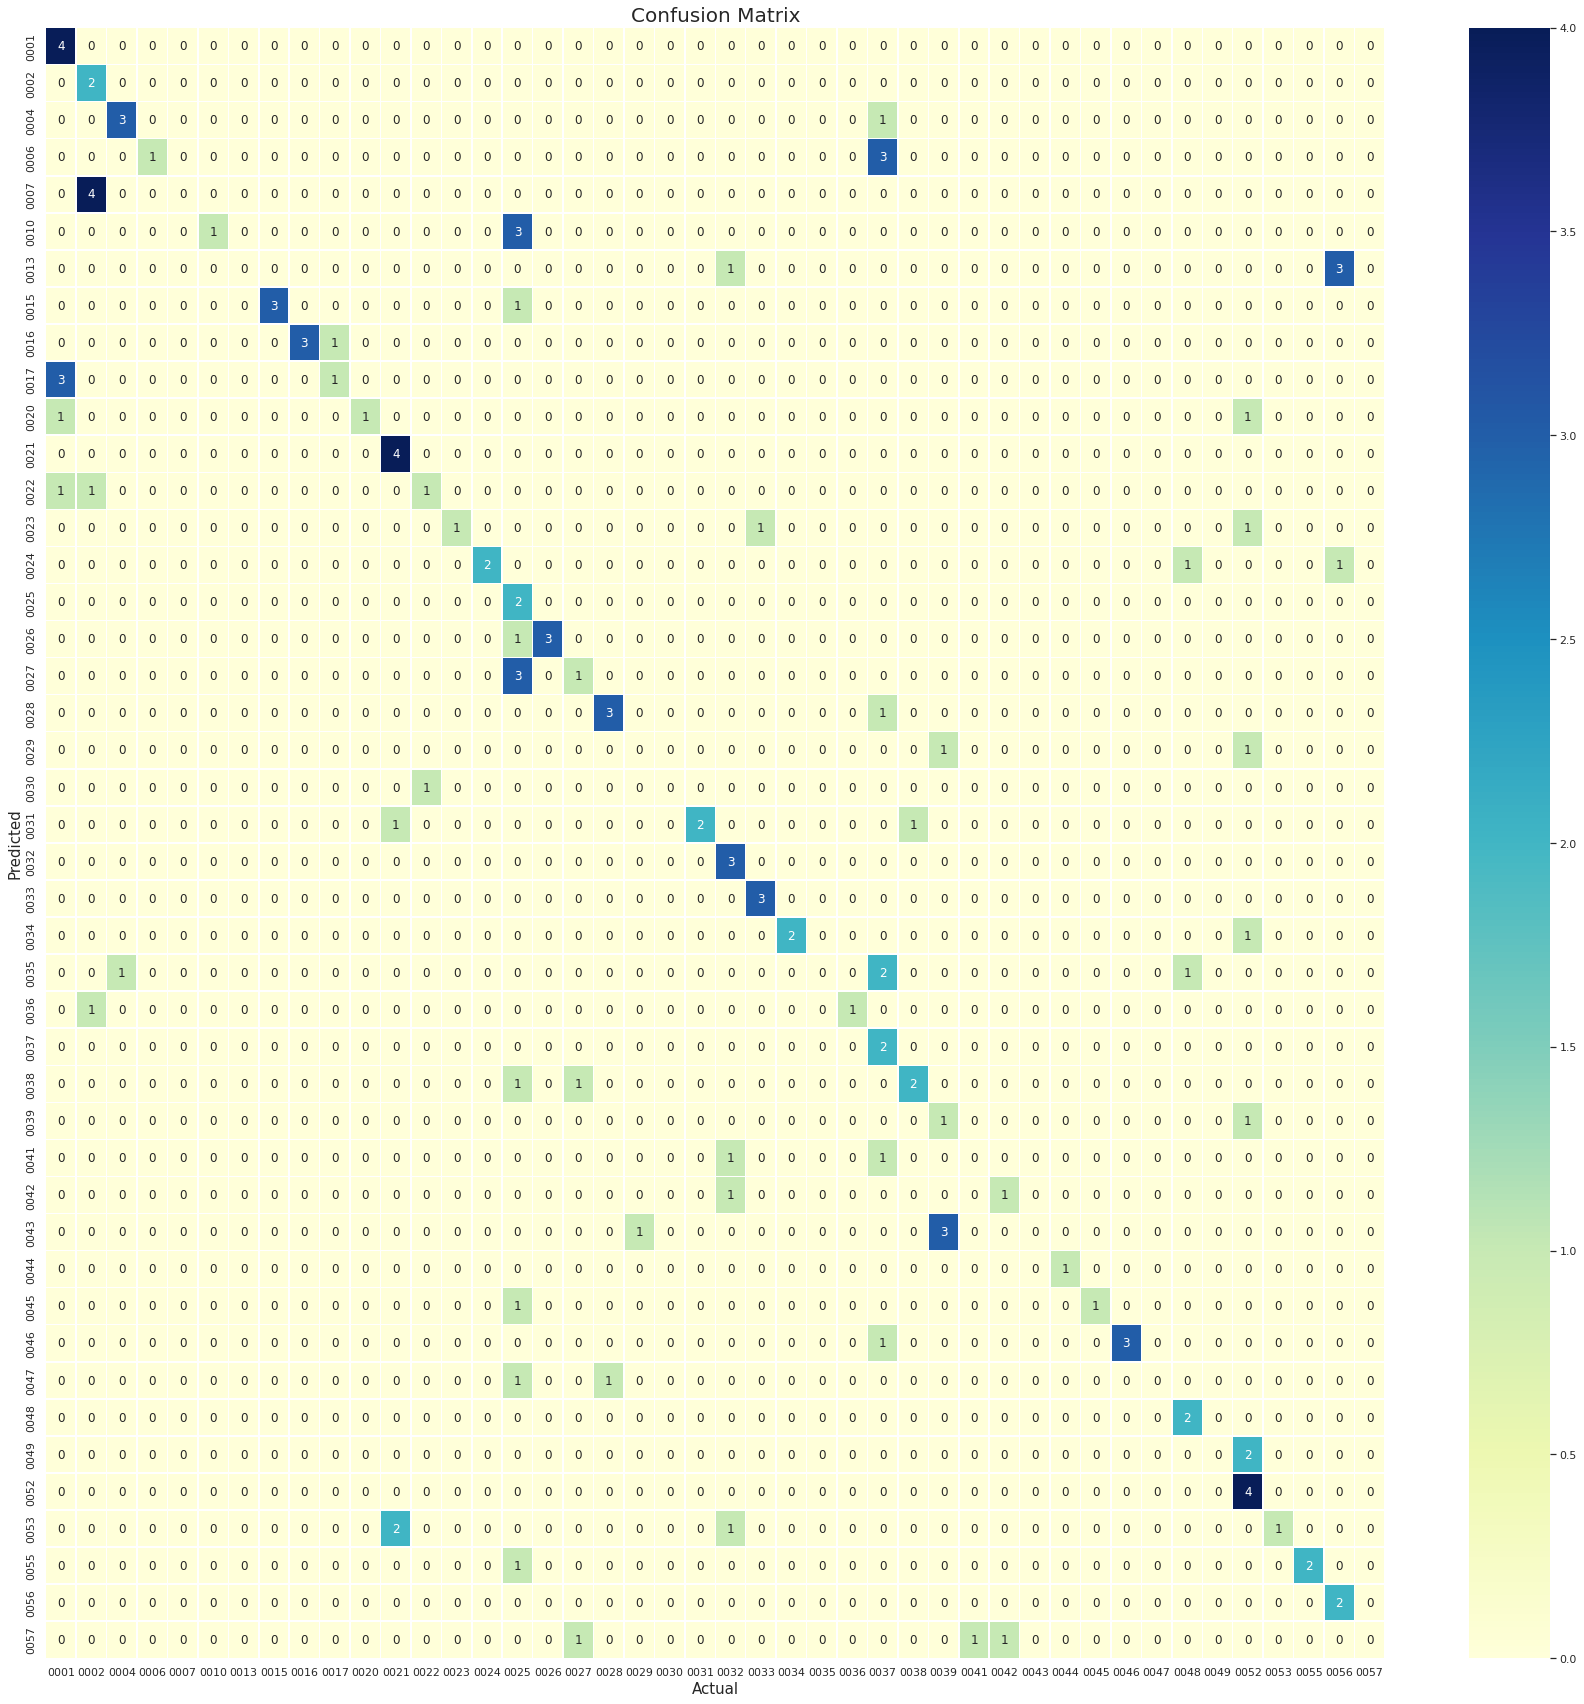

In [ ]:
displayConfusioMatrix(true_labels,predictions_1)

In [ ]:
print(classification_report(predictions_1, true_labels))

              precision    recall  f1-score   support

        0001       1.00      0.44      0.62         9
        0002       1.00      0.25      0.40         8
        0004       0.75      0.75      0.75         4
        0006       0.25      1.00      0.40         1
        0007       0.00      0.00      0.00         0
        0008       0.00      0.00      0.00         2
        0010       0.25      1.00      0.40         1
        0013       0.00      0.00      0.00         0
        0015       0.75      1.00      0.86         3
        0016       0.75      1.00      0.86         3
        0017       0.25      0.50      0.33         2
        0020       0.33      1.00      0.50         1
        0021       1.00      0.57      0.73         7
        0022       0.33      0.50      0.40         2
        0023       0.33      1.00      0.50         1
        0024       0.50      1.00      0.67         2
        0025       1.00      0.14      0.25        14
        0026       0.75    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

**PREDICTION SUR LES 5 PREMIERS DOCUMENTS TROUVES( SEUIL 05)**

In [ ]:
#calcul des prédiction de tous les images test
predictions_5,true_labels=predict(frame_descriptors, frame_images,5)

Prediction: 100%|██████████ [ time left: 00:00 ]


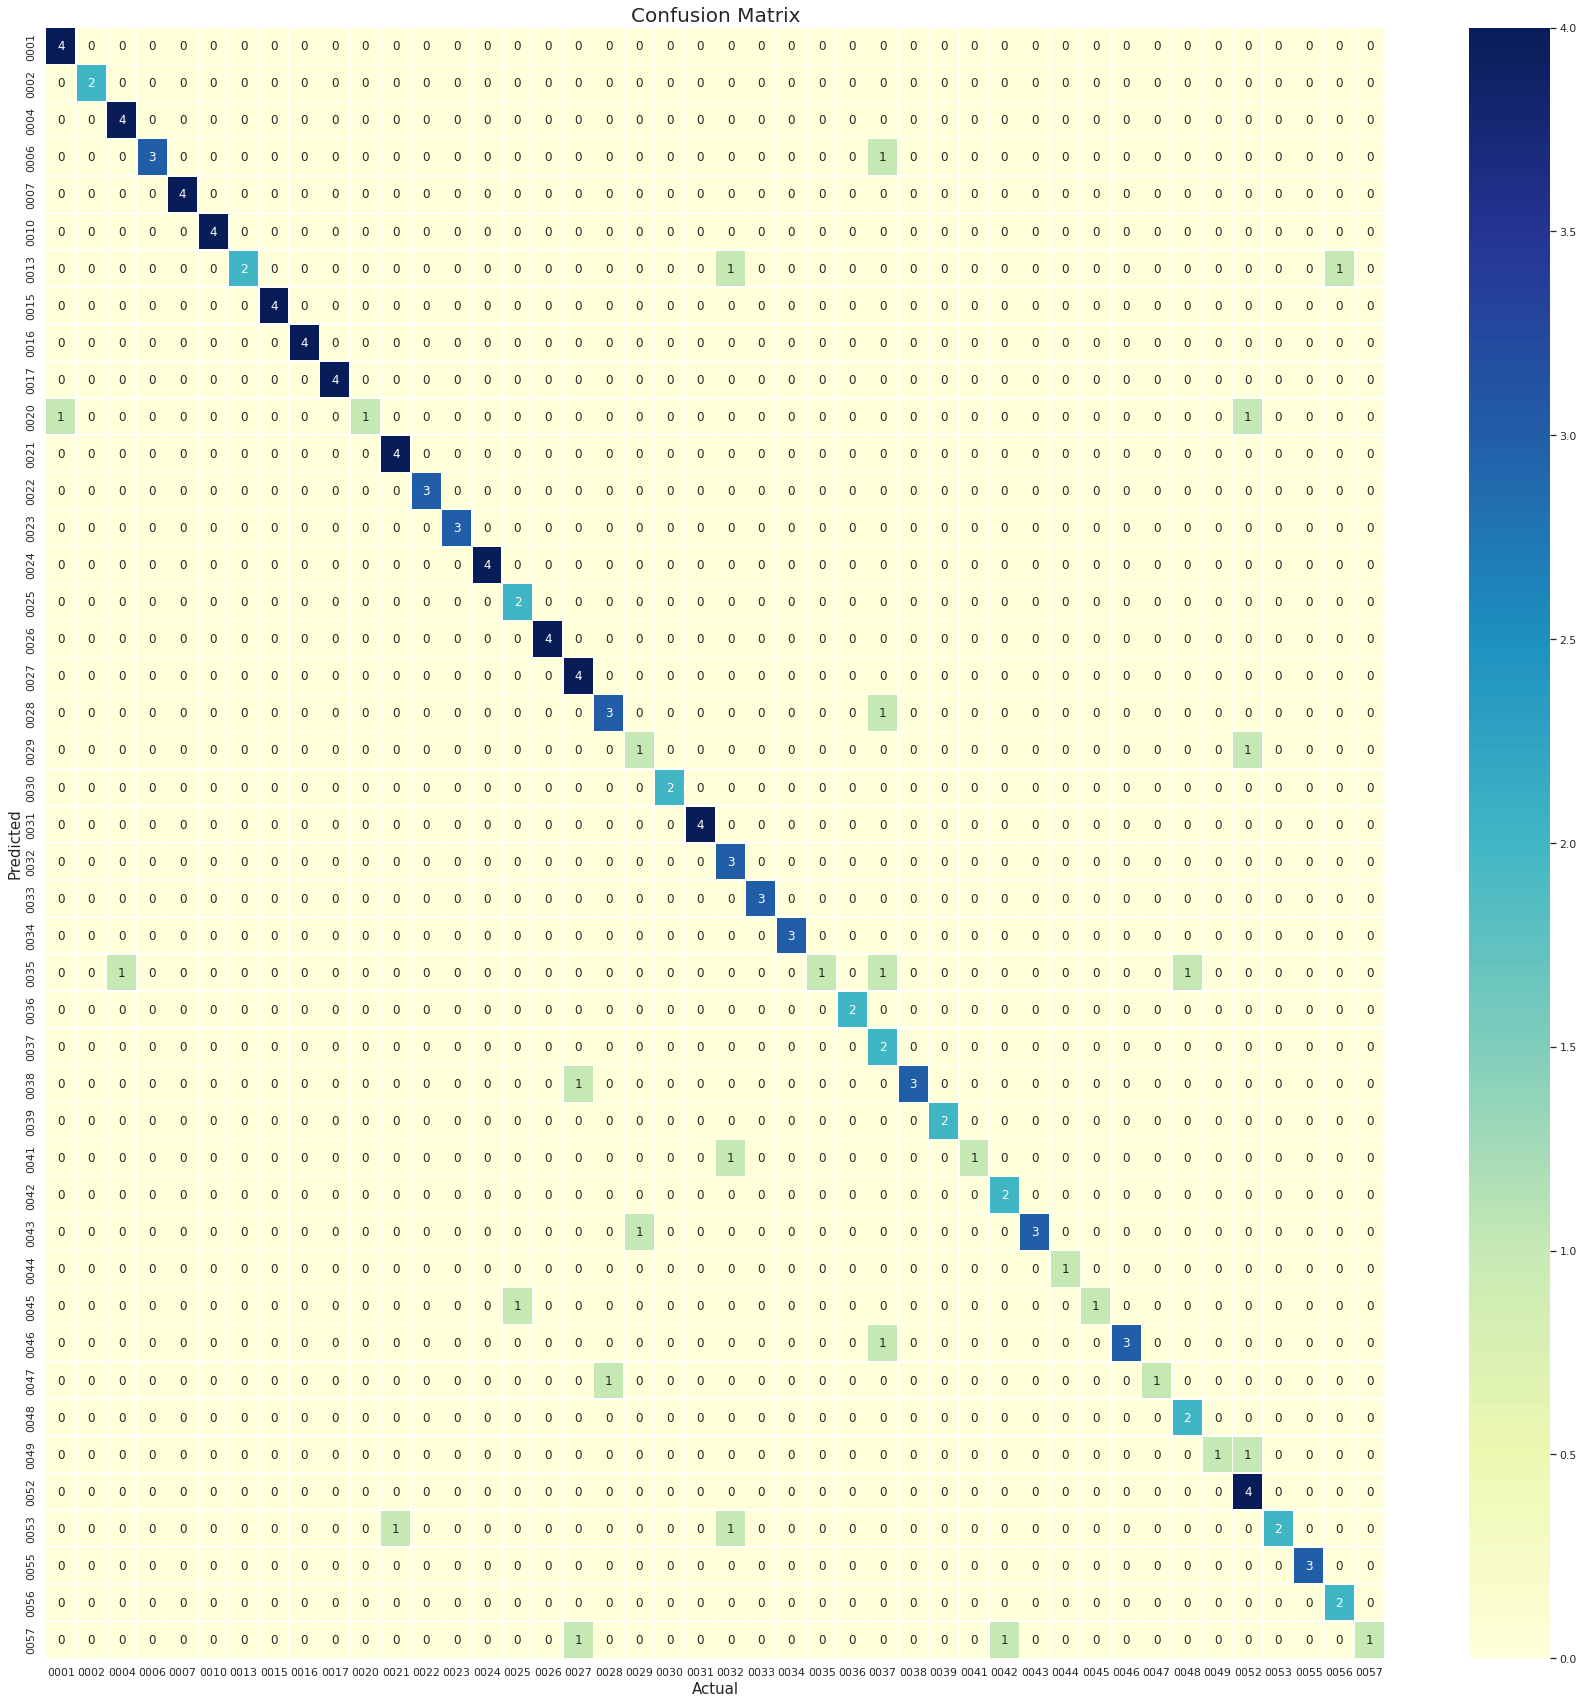

In [ ]:
#affichage des labels uniques
displayConfusioMatrix(true_labels,predictions_5)

In [ ]:
print(classification_report(predictions_5, true_labels))

              precision    recall  f1-score   support

        0001       1.00      0.80      0.89         5
        0002       1.00      1.00      1.00         2
        0004       1.00      0.80      0.89         5
        0006       0.75      1.00      0.86         3
        0007       1.00      1.00      1.00         4
        0008       0.00      0.00      0.00         1
        0010       1.00      1.00      1.00         4
        0013       0.50      1.00      0.67         2
        0015       1.00      1.00      1.00         4
        0016       1.00      1.00      1.00         4
        0017       1.00      1.00      1.00         4
        0020       0.33      1.00      0.50         1
        0021       1.00      0.80      0.89         5
        0022       1.00      1.00      1.00         3
        0023       1.00      1.00      1.00         3
        0024       1.00      1.00      1.00         4
        0025       1.00      0.67      0.80         3
        0026       1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**PREDICTION SUR LES DIX(10) DOCUMENTS**

In [ ]:
predictions_10,true_labels=predict(frame_descriptors, frame_images,10)

Prediction: 100%|██████████ [ time left: 00:00 ]


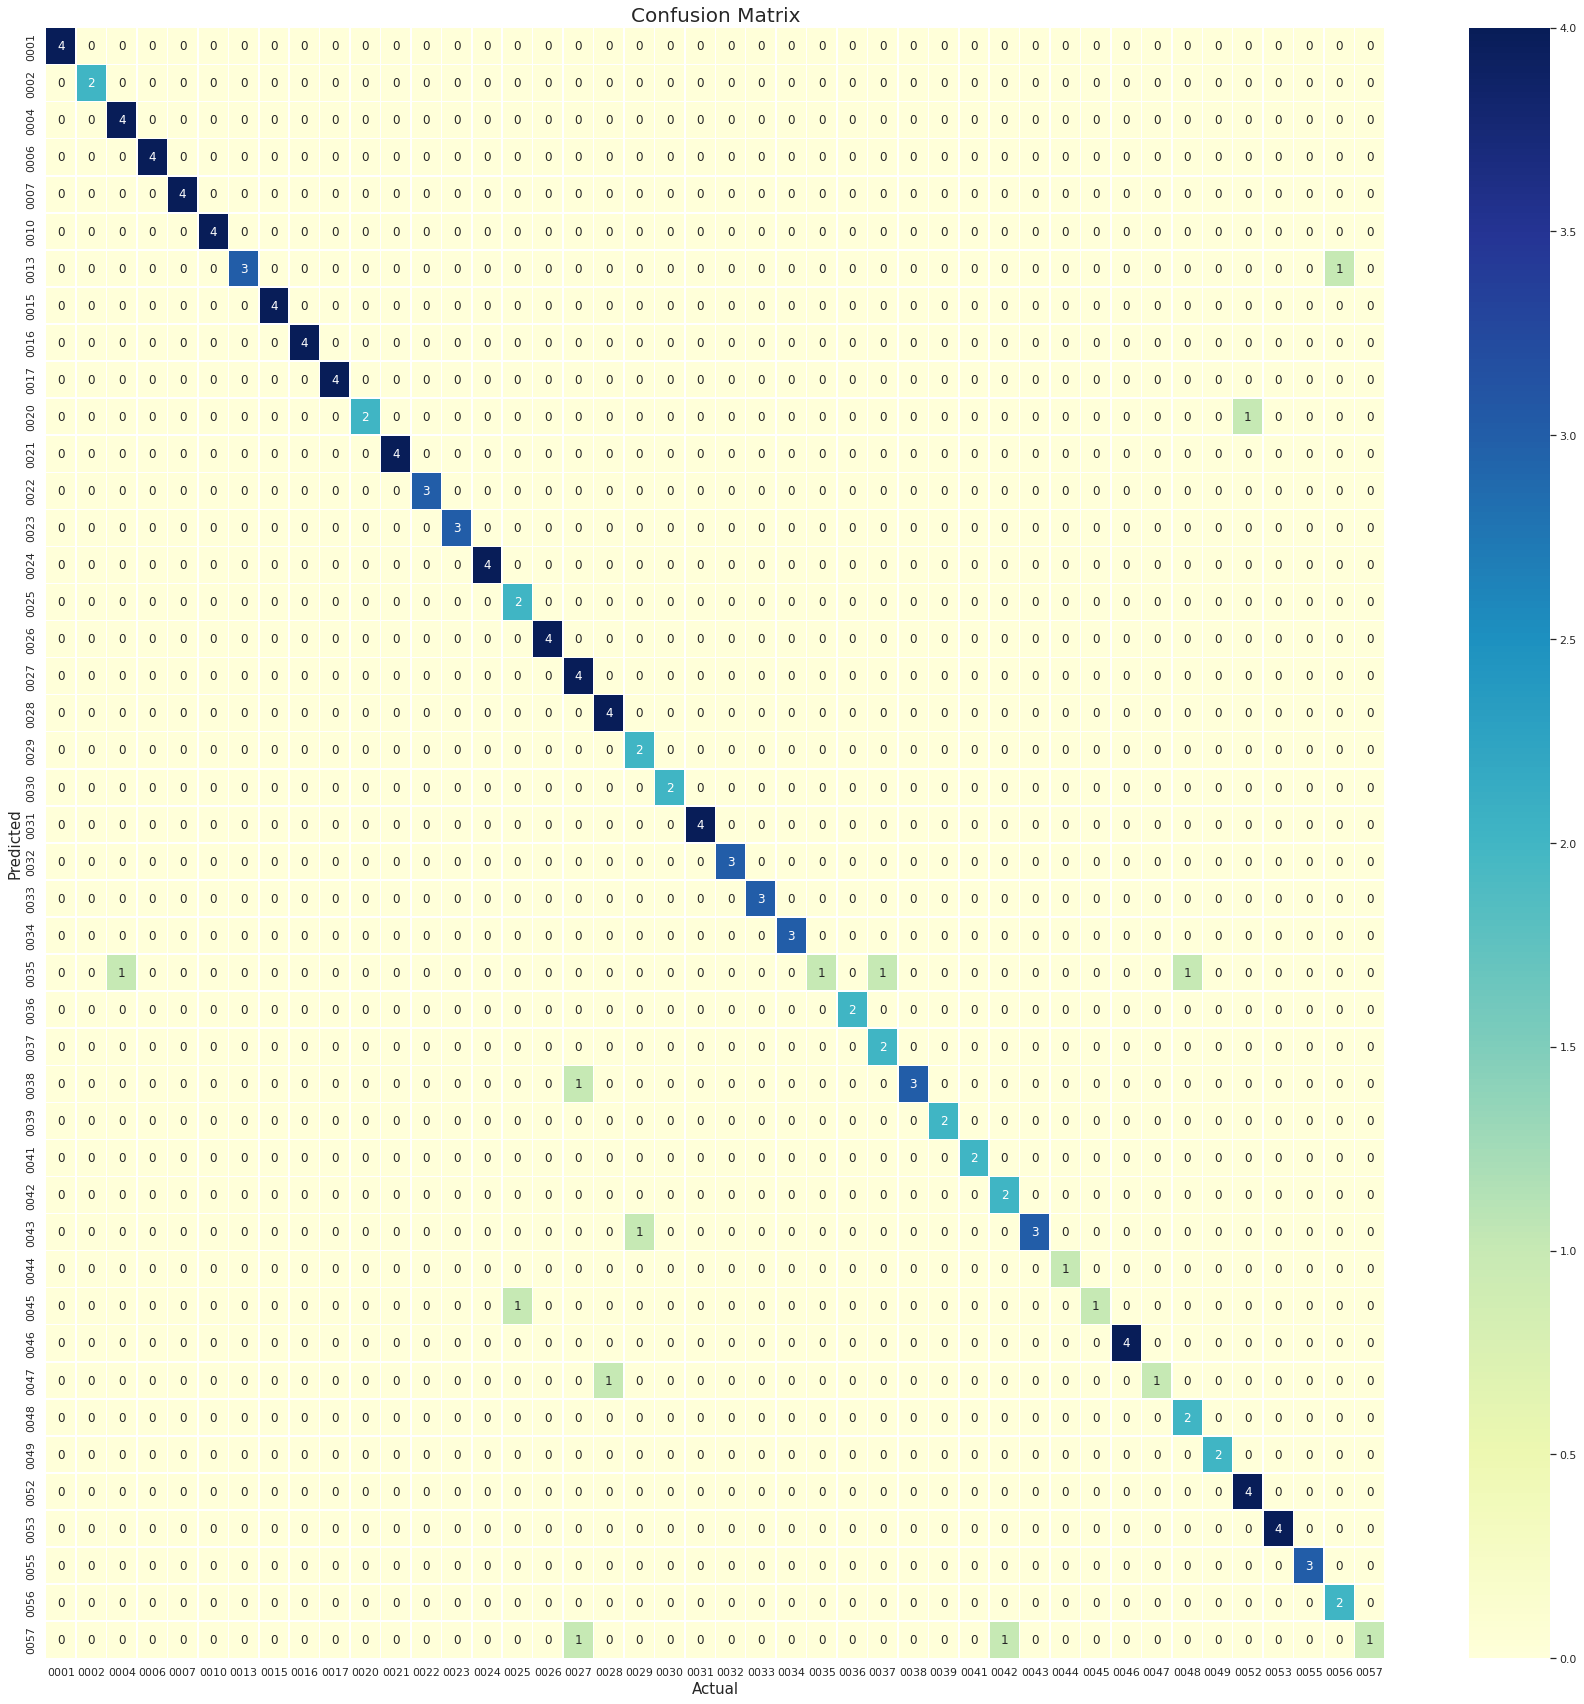

In [ ]:
displayConfusioMatrix(true_labels,predictions_10)

In [ ]:
print(classification_report(predictions_10, true_labels))

              precision    recall  f1-score   support

        0001       1.00      1.00      1.00         4
        0002       1.00      1.00      1.00         2
        0004       1.00      0.80      0.89         5
        0006       1.00      1.00      1.00         4
        0007       1.00      1.00      1.00         4
        0008       0.00      0.00      0.00         1
        0010       1.00      1.00      1.00         4
        0013       0.75      1.00      0.86         3
        0015       1.00      1.00      1.00         4
        0016       1.00      1.00      1.00         4
        0017       1.00      1.00      1.00         4
        0020       0.67      1.00      0.80         2
        0021       1.00      1.00      1.00         4
        0022       1.00      1.00      1.00         3
        0023       1.00      1.00      1.00         3
        0024       1.00      1.00      1.00         4
        0025       1.00      0.67      0.80         3
        0026       1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#TEST AVEC 1000 DESCRIPTEURS



**Calcul des descripteurs avec max 1000**

In [ ]:
mill_descriptors,mill_keypoints,mill_draws=describeImages(train_gray_images, train_images,"sift",1000)

Calcul de descripteur: 100%|██████████ [ time left: 00:00 ]


**Indexation des 1000 descripteurs**

In [ ]:
#indexation des 1000 descripteurs
#dimension
num_dim=len(descriptors['train/0030.jpg'][0])
print(num_dim)
#nombre de tables hash
num_tables=5
lsh=indexation_descripteurs_bases(mill_descriptors,num_dim,num_tables)

128


**Calcul des descriteurs( max 1000) sur les frames**

In [ ]:
mill_frame_descriptors,_,_= describeImages(frame_gray_images, frame_images,"sift",1000)

Calcul de descripteur: 100%|██████████ [ time left: 00:00 ]


**Evaluation avec les 1000 descripteurs**

**Predictions avec seuil 1**

In [ ]:
#calcul des prédiction de tous les images test
predictions_descripteurs_1000,true_labels=predict(mill_frame_descriptors, frame_images,1)

Prediction: 100%|██████████ [ time left: 00:00 ]


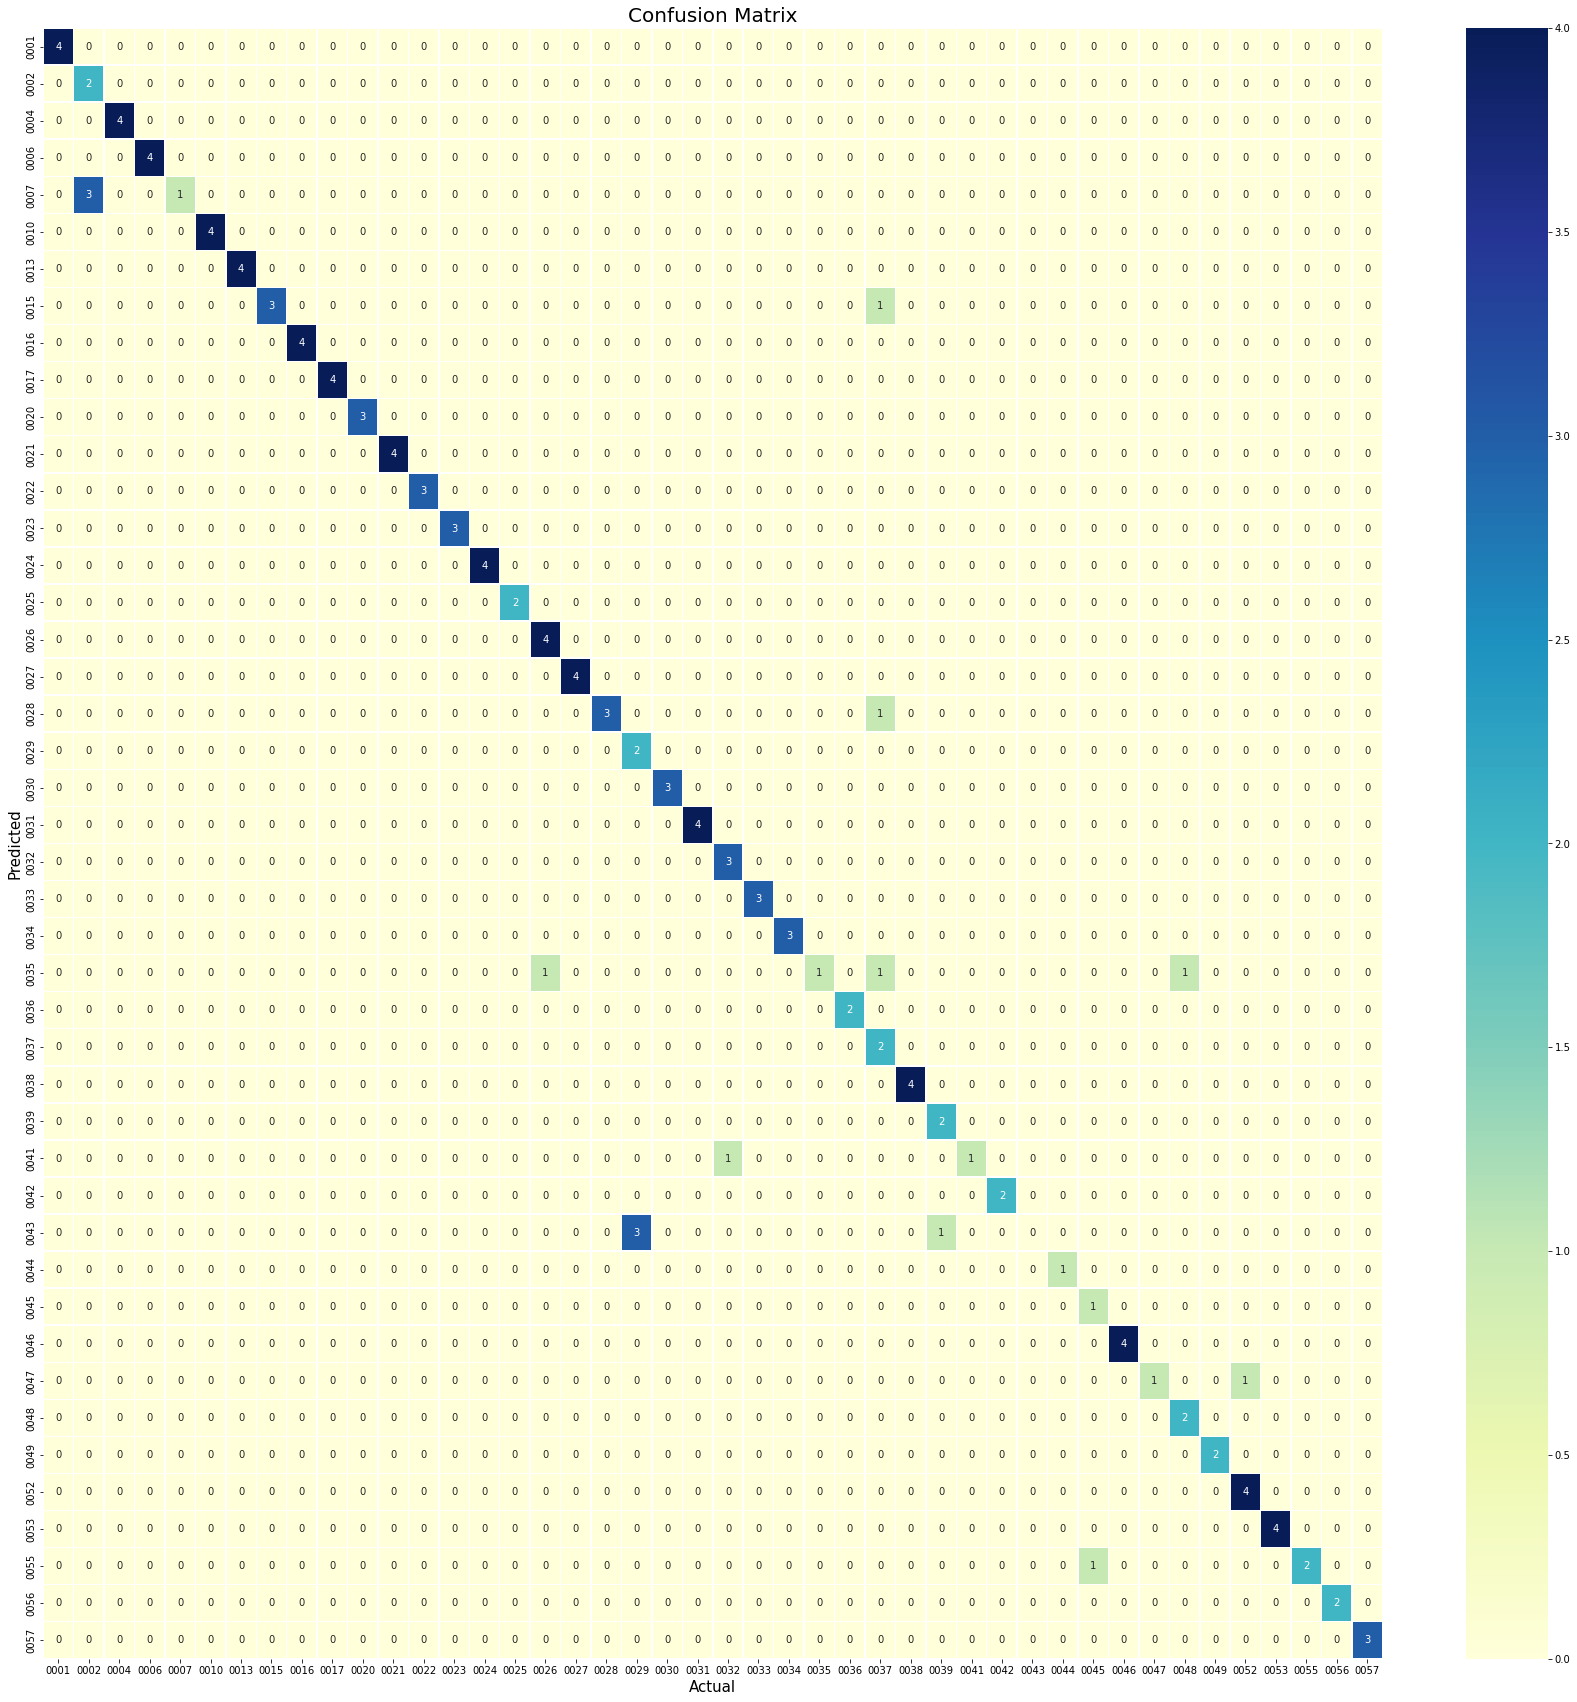

In [ ]:
displayConfusioMatrix(true_labels,predictions_descripteurs_1000)

In [ ]:
print(classification_report(predictions_descripteurs_1000, true_labels))

              precision    recall  f1-score   support

        0001       1.00      1.00      1.00         4
        0002       1.00      0.40      0.57         5
        0004       1.00      1.00      1.00         4
        0006       1.00      1.00      1.00         4
        0007       0.25      1.00      0.40         1
        0008       0.00      0.00      0.00         1
        0010       1.00      1.00      1.00         4
        0013       1.00      1.00      1.00         4
        0015       0.75      1.00      0.86         3
        0016       1.00      1.00      1.00         4
        0017       1.00      1.00      1.00         4
        0020       1.00      1.00      1.00         3
        0021       1.00      1.00      1.00         4
        0022       1.00      1.00      1.00         3
        0023       1.00      1.00      1.00         3
        0024       1.00      1.00      1.00         4
        0025       1.00      1.00      1.00         2
        0026       1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1